In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
from datetime import date
import re
import torch
import matplotlib.pyplot as plt
from pacmap import PaCMAP
from transformers import AutoTokenizer, AutoModel
import arxiv
from sklearn.neighbors import KNeighborsTransformer
from IPython.display import clear_output
from datetime import date
from datetime import timedelta
from pymongo import MongoClient
from datetime import datetime
from torch import nn
from database_utils import *
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
device = 'cpu'
torch.device(device)

device(type='cpu')

In [2]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [3]:
class ClickedDataset(Dataset):
    def __init__(self, abstracts, item_vectors,abstract_map):
        self.item_vectors = item_vectors.astype(np.float32)
        self.abstracts = abstracts
        self.abstract_map = abstract_map

    def __len__(self):
        return len(self.item_vectors)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        abstract = self.abstracts[self.abstract_map[idx]]
        item_vecs = self.item_vectors[idx]
        
        sample = (abstract,item_vecs)

        return sample    
    
class paperBERT(nn.Module):
    def __init__(self, num_papers, latent_dim):
        super(paperBERT, self).__init__()
        self.longformer = AutoModel.from_pretrained('allenai/longformer-base-4096')
        self.tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
        
        self.user_encoder = nn.Sequential(
            nn.Linear(num_papers),
            nn.Linear(512),
            nn.Linear(512),
        )
        
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, latent_dim)
        
    def forward(self,data):
        encoding = self.tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True,
                                                       truncation=True, add_special_tokens = True).to(device)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        
        model_output = self.longformer(
               input_ids, 
               attention_mask=attention_mask)

        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        sequence_output=  mean_pooling(model_output, attention_mask)
        linear1_output = self.linear1(sequence_output.view(-1,768)) ## extract the 1st token's embeddings
        linear2_output = self.linear2(linear1_output)

        return linear2_output
    
    def train(self,data_loader,epochs):
        criterion = nn.MSELoss() ## If required define your own criterion
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

        for epoch in range(epochs):
            for batch in data_loader: ## If you have a DataLoader()  object to get the data.
                
                data = list(batch[0])
                targets = batch[1] ## assuming that data loader returns a tuple of data and its targets
                
                optimizer.zero_grad()   
                outputs = model(data)
                outputs = torch.tanh(outputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
    
    @torch.no_grad()
    def predict(self, data):
        with torch.no_grad():
            encoding = self.tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True,
                                                           truncation=True, add_special_tokens = True).to(device)
            input_ids = encoding['input_ids']
            attention_mask = encoding['attention_mask']

            model_output = self.longformer(
                   input_ids, 
                   attention_mask=attention_mask)

            # sequence_output has the following shape: (batch_size, sequence_length, 768)
            sequence_output=  mean_pooling(model_output, attention_mask)
            print(sequence_output.shape)
            linear1_output = self.linear1(sequence_output.view(-1,768)) ## extract the 1st token's embeddings
            linear2_output = self.linear2(linear1_output)
            outputs = torch.tanh(linear2_output)
        return outputs.numpy()

In [4]:
def loss(X, Y, Z, mask, lam):
    return np.sum( ((Y.T @ Z - X) ** 2)[mask] ) \
       + lam * np.linalg.norm(Y, ord="fro") \
       + lam * np.linalg.norm(Z, ord="fro")

def approximate(data_dense, rank, lam,max_iteration=1000,Y_start=None,Z_start=None):
    # initialize low-rank approximation matrix as a product of two 
    # Y @ Z = X_bar
    data_mask = np.ones(data_dense.shape, dtype=np.bool)
    if Y_start is not None and Z_start is not None:
        Y = Y_start
        Z = Z_start
    else:
        Y = np.random.randn(rank, data_dense.shape[0])
        Z = np.random.randn(rank, data_dense.shape[1])

    # calculation speedup
    lam_I = lam * np.eye(rank)

    # alternating least squares until convergence
    prev_obj = loss(data_dense, Y, Z, data_mask, lam)
    converged = False

    print("Start objective:", prev_obj)

    prev_Y = Y.copy()
    prev_Z = Z.copy()
    for iteration in range(1, max_iteration + 1):
        if iteration % 10 == 0:
            print("Iteration:", iteration)
            print("Current objective:", prev_obj)

        # optimize Y based on current value of Z
        for col in range(Y.shape[1]):
            has_rating = data_mask[col]
            ratings = data_dense[col, has_rating]
            Z_relevant_columns = Z[:, has_rating]
            regularized_cov = np.sum([c.reshape([-1, 1]) @ c.reshape([1, -1]) for
                                    c in Z_relevant_columns.T], axis=0) + lam_I
            weighted_sum = np.sum(Z_relevant_columns * ratings, axis=1)
            Y[:, col] = np.linalg.inv(regularized_cov) @ weighted_sum

        # optimize Z based on current values of Y
        for col in range(Z.shape[1]):
            has_rating = data_mask[:, col]
            ratings = data_dense[has_rating, col]
            Y_relevant_columns = Y[:, has_rating]
            regularized_cov = np.sum([c.reshape([-1, 1]) @ c.reshape([1, -1]) for
                                    c in Y_relevant_columns.T], axis=0) + lam_I
            weighted_sum = np.sum(Y_relevant_columns * ratings, axis=1)
            Z[:, col] = np.linalg.inv(regularized_cov) @ weighted_sum

        obj = loss(data_dense, Y, Z, data_mask, lam)

        # convergence criteria. prevents division by 0.
        if abs(obj - prev_obj) / ( abs(prev_obj) + 1e-8 ) < TOLERANCE:
            converged = True
            break

        prev_obj = obj

    print("Converged:", converged)
    print("# iterations:", iteration)
    print("Final objective:", obj)

    # report final low-rank matrix
    return Y.T, Z.T

In [136]:
PERPLEXITY=5
g_kernel=1
EPOCHS=2000
LR=200
MOMENTUM=0.99

def getKey(item):
    return item[1]

def k_neighbours(x,x1_index,p_or_q='p'):
    x1=x[x1_index]
    list_k_neighbours=[]
    for i in range(x.shape[0]):
        if i!=x1_index:
            xi=x[i]
            if p_or_q=='p':
                distance=np.exp(-np.linalg.norm(x1-xi)**2/(2*g_kernel**2))
            else:
                distance=(1+np.linalg.norm(x1-xi)**2)**-1
            list_k_neighbours.append([i,distance])
    
    list_k_neighbours=sorted(list_k_neighbours,key=getKey)
    return list_k_neighbours[:PERPLEXITY]

#compute the similarity pij between two xi,xj in the original space
#divide the distance between xi,xj by the sum of the distances of the k_neightbours where k is the complexity
def compute_pij(x,x1_index,x2_index):
    x1=x[x1_index]
    x2=x[x2_index]
    # num=(1+np.linalg.norm(x1-x2)**2)**(-1)/(2*g_kernel**2))
    num=np.exp(-np.linalg.norm(x1-x2)**2)/(2*g_kernel**2)
    denom=0
    list_k_neighbours=k_neighbours(x,x1_index,'p')
    for i in list_k_neighbours:
        denom+=i[1]
    return num/denom


#compute the table p of the xij in the original space
def compute_p(x):
    table=np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i!=j:
                pij=compute_pij(x,i,j)
                pji=compute_pij(x,j,i)
                table[i,j]=(pij+pji)/(2*x.shape[0])
                # table[i,j]=pij
    return table

#compute the similarity qij between two yi,yj in the new space
#divide the distance between yi,yj by the sum of the distances of the k_neightbours where k is the complexity
def compute_qij(y,y1_index,y2_index):
    y1=y[y1_index]
    y2=y[y2_index]
    num=(1+np.linalg.norm(y1-y2)**2)**(-1)
    denom=0
    for i in k_neighbours(y,y1_index,'q'):
        denom+=i[1]
    return num/denom

#compute the table q of the yij in the new space
def compute_q(y):
    table=np.zeros((y.shape[0],y.shape[0]))
    for i in range(y.shape[0]):
        for j in range(y.shape[0]):
            if i!=j:
                qij=compute_qij(y,i,j)
                table[i,j]=qij
    return table

#compute the erros between the 2 distributions using the KL-divergence
def kl_divergence(p,q):
    total=0
    for i in range(p.shape[0]):
        for j in range(q.shape[0]):
            if q[i,j]!=0 and p[i,j]!=0:
                total+=p[i,j]*np.log(p[i,j]/q[i,j])
    return total

#apply gradient descent to lower the KL-divergence
def gradient_descent(p,q,y):
    for iter in range(EPOCHS):
        for i in range(y.shape[0]):
            sum_value=0
            for j in range(y.shape[0]):
                sum_value+=((y[i]-y[j])*(p[i,j]-q[i,j])*(1+np.linalg.norm(y[i]-y[j]**2))**-1)
            y[i]-=4*LR*sum_value
        if iter%100==0:
            q=compute_q(y)
            print(kl_divergence(p,q)) 
    y-=np.mean(y)
    y/=np.std(y)
    return y

-2.0057338434021394
-2.1335419988078357
-1.9680415939387885
-1.8914396273111955
-1.9006524228198989
-1.907040772273569
-1.9121968860199015
-1.9163363996108063
-1.9197779080547117
-1.9227015474756448
-1.9253303471575576
-1.9286719987634215
-1.9318542212177308
-1.9347427104220827
-1.937375094134231
-1.9397818032904157
-1.9419879497534491
-1.944014595473558
-1.9459573495486664
-1.9483910356004341


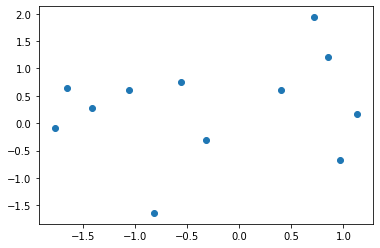

In [139]:
table_p=compute_p(abstracts)

pca = PCA(n_components=2)
y = pca.fit_transform(abstracts)

table_q=compute_q(y)
y=gradient_descent(table_p,table_q,y)

plt.scatter(y[:,0],y[:,1])
plt.show()

In [54]:
def generate_interaction_matrix():
    client = MongoClient(URI)
    
    # get all users recently viewed
    db = client.papers.users
    
    all_viewed = db.find({},{"recently_viewed":1})
    users_viewed = list(all_viewed)
    
    # get all papers and their ids
    db = client.papers.papers
    
    all_paper_ids = db.find({"number_of_clicks":{"$gt":0}},{"_id":1})
    all_ids = list(all_paper_ids)
    
    # make dictionary between paper id and index in array
    paper_index_map = {}
    
    i=0
    for dic in all_ids:
        paper_index_map[dic["_id"]] = i
        i+=1
    
    # make array of zeroes with shape (users,papers)
    clicked = np.zeros((len(users_viewed),len(all_ids)))
    print(clicked.shape)
    # for all users recently viewed change 0 in array to a 1
    user_index_map = {}
    i=0
    for user in users_viewed:
        user_index_map[user["_id"]] = i
        
        for paper in user["recently_viewed"]:
            if paper in paper_index_map:
                clicked[i,paper_index_map[int(paper)]] = 1
        
        i+=1
    
    return clicked,user_index_map, paper_index_map

In [328]:
from sklearn.decomposition import PCA

def user_factorize(data, paper_vectors, latent_dim,learnining_rate=.1,lmbda=.1,lmbda2=.05,user_start=None, max_iter=1000):
    pca = PCA(n_components=latent_dim)
    U_comp =pca.fit_transform(paper_vectors).T
    m,n = data.shape
    P = np.random.uniform(0,latent_dim**.5,size=(latent_dim,m))
    
    U = np.random.uniform(0,latent_dim**.5,size=(latent_dim,n))
    U = U_comp
    
    loss = []
    
    users, items = data.nonzero()
    
    for i in range(max_iter):
        for u,p in zip(users, items):
            error = data[u,p] - U[:,p]*P[:,u]
            P[:,u] += learnining_rate * (error * U[:,p] - lmbda* P[:,u])
            U[:,p] += learnining_rate * (error * P[:,u] - lmbda* U[:,p])
            
        total_error = np.linalg.norm(data- P.T@U,"fro") 
        loss.append(total_error)
    return P.T, U.T, loss

In [345]:
P,U,loss = user_factorize(rat, abstracts, 2,learnining_rate=.1, max_iter=200,lmbda=.5)

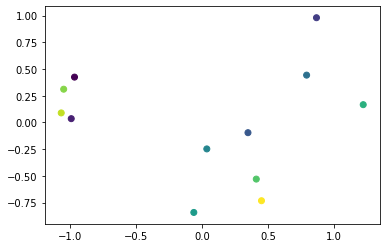

In [346]:
pca = PCA(n_components=2)
y = pca.fit_transform(abstracts)
plt.scatter(y[:,0],y[:,1],c=range(12))
plt.show()

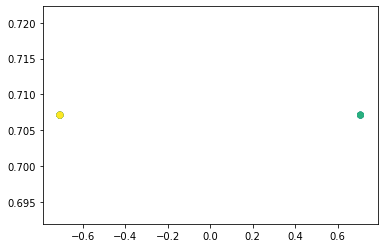

In [347]:
plt.scatter(U[:,0],U[:,1],c=range(12))
plt.show()

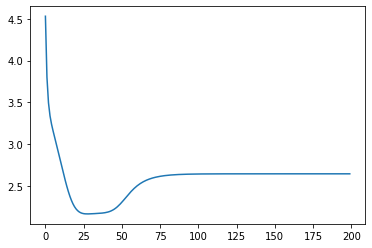

In [348]:
plt.plot(loss)

In [349]:
pred =P@U.T

In [350]:
pred,rat

(array([[ 9.99999999e-01,  9.99999999e-01,  9.99999953e-01,
          9.99999952e-01, -4.07106118e-10, -7.24073823e-10,
         -1.39822294e-09, -9.34775931e-10,  9.99999997e-01,
          9.99999964e-01,  9.99999968e-01,  1.00000000e+00],
        [-6.03631056e-10, -1.11466760e-09,  4.74049188e-08,
          4.63252212e-08,  1.00000000e+00,  9.99999999e-01,
          9.99999998e-01,  9.99999999e-01, -2.20293969e-11,
          3.54067091e-08,  3.09508313e-08, -1.30431733e-15],
        [ 9.99999999e-01,  9.99999999e-01,  9.99999953e-01,
          9.99999952e-01, -4.07104120e-10, -7.24071825e-10,
         -1.39822094e-09, -9.34773933e-10,  9.99999997e-01,
          9.99999964e-01,  9.99999968e-01,  1.00000000e+00]]),
 array([[1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]]))

In [37]:
abstracts,new_map = get_abstracts_by_ids(paper_index_map)

In [47]:
# Hyperparameters
latent_dim = 2
MAX_ITERATION = 1000
TOLERANCE = 1e-4

# Get clicked matrix along with the mappings 
rat,user_index_map,paper_index_map = generate_interaction_matrix()

# Factorize matrix
U,P = approximate(rat, latent_dim, 1)

# get abstracts for input to longformer
abstracts,new_map = get_abstracts_by_ids(paper_index_map)

# Make PyTorch data loader
dataset = ClickedDataset(abstracts, P,new_map)
data_loader = DataLoader(dataset, batch_size=10,shuffle=True)

# Create Model
model = paperBERT(latent_dim) # You can pass the parameters if required to have more flexible model
model.to(device) ## can be gpu

Start objective: 3848.4516061954655
Converged: True
# iterations: 8
Final objective: 5.518658841793084


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


paperBERT(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_feat

In [6]:
papers_latent_prediction_before_train = model.predict(list(abstracts[:10]))

torch.Size([10, 768])


In [9]:
U@papers_latent_prediction_before_train

array([[ 0.01132876, -0.23788672,  0.23825852, -0.02143954,  0.00349622,
         0.05581367, -0.04997552,  0.09560195, -0.03817378, -0.02161047]])

In [12]:
rat[0,:10]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [13]:
model.train(data_loader,5)

In [14]:
papers_latent_prediction_after_train = model.predict(list(abstracts[:10]))

torch.Size([10, 768])


In [16]:
papers_latent_prediction_after_train

array([[ 0.000986  ,  0.000987  , -0.00341318,  0.00641557, -0.00110761,
        -0.000543  ,  0.00429675,  0.00060941,  0.00138234, -0.00150365],
       [ 0.00098602,  0.00098701, -0.00341317,  0.00641559, -0.0011076 ,
        -0.00054299,  0.00429678,  0.00060939,  0.00138236, -0.00150365],
       [ 0.00098598,  0.00098703, -0.00341321,  0.00641562, -0.00110759,
        -0.00054298,  0.00429678,  0.00060939,  0.00138233, -0.00150368],
       [ 0.00098598,  0.00098704, -0.0034132 ,  0.00641558, -0.00110761,
        -0.00054294,  0.00429673,  0.00060936,  0.00138234, -0.00150369],
       [ 0.00098598,  0.000987  , -0.0034132 ,  0.00641561, -0.0011076 ,
        -0.00054297,  0.00429674,  0.00060939,  0.00138235, -0.0015037 ],
       [ 0.000986  ,  0.00098701, -0.00341316,  0.00641561, -0.00110759,
        -0.00054298,  0.00429677,  0.0006094 ,  0.00138233, -0.00150367],
       [ 0.00098598,  0.00098702, -0.00341321,  0.00641561, -0.0011076 ,
        -0.00054295,  0.00429678,  0.00060938

In [2]:
get_last_days_papers()

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
